# Investigate Examples
In this notebook I'll analyze which GLUE examples the adaptive models outperform the base roberta model, after Fabrizio's suggestion. 

The goal here is to develop an intuition or identify a pattern to the examples on which adaptive models outperform. 

### Evaluation Process
The evaluation process is quite simple: in the `investigate_adaptive.py` script, and more generally the `investigate_adaptive.sh` script, I load all three models of the same group: **Finetuned** or **Baseline**. I load the *roberta* model, which serves as our comparison, as well as the two adaptive models, *adaptive* and *sparse*. All models have a learning rate of 1e-4 and batch size of 44. The difference between **Finetuned** and **Baseline** is that the finetuned models are finetuned for 10 epochs. 

**Note
I made a small mistake and forgot to separate the **finetuned** and **baseline** models, so I restarted the process. I'll still start analyzing for now. 

# Imports

In [28]:
import os
import dotenv
dotenv.load_dotenv()

from tqdm import tqdm

from preprocessing import get_dataloader
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Variables

In [29]:
STORAGE_DIR = os.getenv("STORAGE_DIR")
print(STORAGE_DIR)
datasets_path = os.path.join(STORAGE_DIR, "datasets")
examples_path = STORAGE_DIR + "/models/finetune_roberta/investigate_examples"

tasks = ["cola", "mnli", "mrpc", "qnli", "qqp", "rte", "sst2", "wnli"]        
task_colors = ["#E3B505", "#EF2D56", "#ED7D3A", "#3D348B", "#2FBF71", "#064789", "#B388EB", "#05B2DC"]
task_colors = dict(zip(tasks, task_colors))

model_colors = {"adaptive":"#20A39E", "sparse":"#FFBA49"}


/home/lvpoellhuber/storage


# Cleanup

In [30]:
def clean_adaptive_df(path):
    all_lines = []
    with open(path, "r") as adaptive_file:
        for line in adaptive_file.readlines():
            if len(line.split(";")>3):
                columns = line.split(";")
                line = ";".join()
            else:
                all_lines.append(line)

## Reading files


In [31]:
finetuned_adaptive_df = pd.read_csv(os.path.join(examples_path, "finetuned_adaptive_examples.csv"), delimiter = ";", header=None)
finetuned_adaptive_df.columns = ["task", "text", "label"]
finetuned_adaptive_df["group"] = "finetuned"

baseline_adaptive_df = pd.read_csv(os.path.join(examples_path, "baseline_adaptive_examples.csv"), delimiter = ";", header=None)
baseline_adaptive_df.columns = ["task", "text", "label"]
baseline_adaptive_df["group"] = "baseline"

adaptive_df = pd.concat([finetuned_adaptive_df, baseline_adaptive_df]) 

finetuned_sparse_df = pd.read_csv(os.path.join(examples_path, "finetuned_sparse_examples.csv"), delimiter = ";", header=None)
finetuned_sparse_df.columns = ["task", "text", "label"]
finetuned_sparse_df["group"] = "finetuned"

baseline_sparse_df = pd.read_csv(os.path.join(examples_path, "baseline_sparse_examples.csv"), delimiter = ";", header=None)
baseline_sparse_df.columns = ["task", "text", "label"]
baseline_sparse_df["group"] = "baseline"

sparse_df = pd.concat([finetuned_sparse_df, baseline_sparse_df]) 

In [32]:
temp_adaptive_df = adaptive_df
temp_adaptive_df["model"] = "adaptive"
temp_sparse_df = sparse_df
temp_sparse_df["model"] = "sparse"

general_adaptive_df = pd.concat([temp_adaptive_df, temp_sparse_df])
general_adaptive_df

,task,text,label,group,model
0,cola,John left orders not to be disturbed.,1,finetuned,adaptive
1,cola,The bears sniffed,1,finetuned,adaptive
2,cola,Henry found that Bill is sad.,1,finetuned,adaptive
3,cola,The tub leaked water.,1,finetuned,adaptive
4,cola,The defendant walks.,1,finetuned,adaptive
...,...,...,...,...,...
36676,sst2,even if you do n't think ( kissinger 's ) any ...,1,baseline,sparse
36677,sst2,griffiths proves she 's that rare luminary who...,1,baseline,sparse
36678,sst2,"a moody , multi-dimensional love story and sci...",1,baseline,sparse
36679,sst2,a romantic comedy enriched by a sharp eye for ...,1,baseline,sparse


## Accuracy Metrics

In [33]:
finetuned_accuracy = pd.read_csv("/home/lvpoellhuber/storage/models/finetune_roberta/investigate_examples/finetuned_accuracy.csv", header=None)
finetuned_accuracy = pd.pivot_table(finetuned_accuracy, values=0, columns=2, index=1)
finetuned_accuracy.index = finetuned_accuracy.index.astype(str) + "_ft"
finetuned_accuracy.index.name = None
finetuned_accuracy.columns.name = None

baseline_accuracy = pd.read_csv("/home/lvpoellhuber/storage/models/finetune_roberta/investigate_examples/baseline_accuracy.csv", header=None)
baseline_accuracy = pd.pivot_table(baseline_accuracy, values=0, columns=2, index=1)
baseline_accuracy.index = baseline_accuracy.index.astype(str) + "_bl"
baseline_accuracy.index.name = None
baseline_accuracy.columns.name = None

accuracy_df = pd.concat([finetuned_accuracy, baseline_accuracy])
accuracy_df = accuracy_df.loc[["roberta_bl", "roberta_ft", "adaptive_bl", "adaptive_ft", "sparse_bl", "sparse_ft"]]
accuracy_df

,cola,mnli,mrpc,qnli,qqp,rte,sst2,wnli
roberta_bl,0.309028,0.354133,0.664975,0.505274,0.368177,0.485417,0.492045,0.564286
roberta_ft,0.654356,0.671940,0.743812,0.767988,0.869799,0.593056,0.781818,0.564286
adaptive_bl,0.309028,0.354336,0.664975,0.505274,0.631823,0.514583,0.507955,0.435714
adaptive_ft,0.682765,0.327449,0.664842,0.505509,0.631833,0.462500,0.509091,0.564286
sparse_bl,0.368687,0.327449,0.664975,0.505274,0.631823,0.503472,0.507955,0.564286
sparse_ft,0.317235,0.354394,0.335158,0.494491,0.631833,0.537500,0.490909,0.564286


In [34]:
acc_index_dict = {"roberta_baseline":"roberta_bl", "roberta_1":"roberta_ft", "roberta_0": "drop", 
                  "adaptive_baseline":"adaptive_bl", "adaptive_1":"adaptive_ft", "adaptive_0": "drop",  
                  "sparse_baseline":"sparse_bl", "sparse_1":"sparse_ft", "sparse_0": "drop"} 

ref_accuracy_df = pd.read_csv("/home/lvpoellhuber/storage/models/finetune_roberta/avg_metrics.csv", index_col = 0)
ref_accuracy_df.index = pd.Series(ref_accuracy_df.index).replace(acc_index_dict)
ref_accuracy_df = ref_accuracy_df.drop("drop")
ref_accuracy_df

,cola,mnli,mrpc,qnli,qqp,rte,sst2,wnli
roberta_bl,0.695,0.327,0.665,0.506,0.368,0.470,0.509,0.452
roberta_ft,0.662,0.672,0.744,0.769,0.870,0.619,0.781,0.562
adaptive_bl,0.695,0.318,0.665,0.506,0.608,0.478,0.491,0.436
adaptive_ft,0.692,0.327,0.665,0.505,0.632,0.471,0.512,0.565
sparse_bl,0.687,0.318,0.335,0.495,0.632,0.478,0.510,0.564
sparse_ft,0.312,0.355,0.335,0.494,0.632,0.525,0.498,0.528


In [35]:
accuracy_df - ref_accuracy_df

,cola,mnli,mrpc,qnli,qqp,rte,sst2,wnli
roberta_bl,-0.385972,0.027133,-0.000025,-0.000726,0.000177,0.015417,-0.016955,0.112286
roberta_ft,-0.007644,-0.000060,-0.000188,-0.001012,-0.000201,-0.025944,0.000818,0.002286
adaptive_bl,-0.385972,0.036336,-0.000025,-0.000726,0.023823,0.036583,0.016955,-0.000286
adaptive_ft,-0.009235,0.000449,-0.000158,0.000509,-0.000167,-0.008500,-0.002909,-0.000714
sparse_bl,-0.318313,0.009449,0.329975,0.010274,-0.000177,0.025472,-0.002045,0.000286
sparse_ft,0.005235,-0.000606,0.000158,0.000491,-0.000167,0.012500,-0.007091,0.036286


# Performance Stochasticity
I've observed that the performance varies from one evaluation attempt to another. To study whether the results really are stochastic, I've run the evaluation process five additional times. 

In [72]:
stoch_accuracy_df = pd.read_csv("/home/lvpoellhuber/storage/models/finetune_roberta/avg_metrics_stoch.csv", index_col = 0)
stoch_accuracy_df.index = pd.Series(stoch_accuracy_df.index).replace(acc_index_dict)

diff = stoch_accuracy_df - stoch_accuracy_df.groupby(stoch_accuracy_df.index).mean()


In [73]:
stoch_accuracy_df.std()

cola    0.188841
mnli    0.128937
mrpc    0.177069
qnli    0.102199
qqp     0.147556
rte     0.040701
sst2    0.106767
wnli    0.061212
dtype: float64

# Task Proportion
Which tasks are adaptive models more often better at?

In [38]:
task_sizes = []

for task in tasks:
    test_dataset_path = os.path.join(datasets_path, os.path.join(task, task+"_test.pt"))
    dataloader = get_dataloader(1, test_dataset_path)

    task_sizes.append(len(dataloader))

print(task_sizes)

task_df = pd.Series(task_sizes, index=tasks)
task_df

[1043, 9815, 1725, 5463, 40430, 277, 872, 71]


cola     1043
mnli     9815
mrpc     1725
qnli     5463
qqp     40430
rte       277
sst2      872
wnli       71
dtype: int64

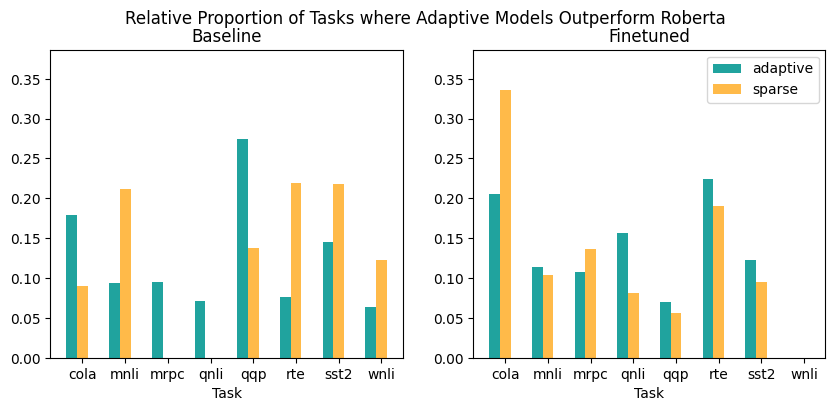

In [39]:
adp_proportions = (baseline_adaptive_df["task"].value_counts() / task_df).fillna(0)
sps_proportions = (baseline_sparse_df["task"].value_counts() / task_df).fillna(0)

adp_proportions = adp_proportions / adp_proportions.sum()
sps_proportions = sps_proportions / sps_proportions.sum()

baseline_max = max(adp_proportions.max(), sps_proportions.max())

bar_width = 0.25
adp_pos = np.arange(len(adp_proportions)) #- bar_width / 2 # halfway to the left
sps_pos = adp_pos + bar_width # halfway to the right

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)

ax1.bar(adp_pos, adp_proportions, color=model_colors["adaptive"], width=bar_width, label="adaptive")
ax1.bar(sps_pos, sps_proportions, color=model_colors["sparse"], width=bar_width, label="sparse")

ax1.set_xlabel("Task")
ax1.set_xticks(adp_pos + bar_width)
ax1.set_xticklabels(adp_proportions.index)

ax1.set_title("Baseline")


adp_proportions = (finetuned_adaptive_df["task"].value_counts() / task_df).fillna(0)
sps_proportions = (finetuned_sparse_df["task"].value_counts() / task_df).fillna(0)

adp_proportions = adp_proportions / adp_proportions.sum()
sps_proportions = sps_proportions / sps_proportions.sum()

finetune_max = max(adp_proportions.max(), sps_proportions.max())

ax2 = plt.subplot(1, 2, 2)

ax2.bar(adp_pos, adp_proportions, color=model_colors["adaptive"], width=bar_width, label="adaptive")
ax2.bar(sps_pos, sps_proportions, color=model_colors["sparse"], width=bar_width, label="sparse")

ax2.set_xlabel("Task")
ax2.set_xticks(adp_pos + bar_width)
ax2.set_xticklabels(adp_proportions.index)

ax2.set_title("Finetuned")

ax1.set_ylim([0, max(finetune_max, baseline_max)+0.05])
ax2.set_ylim([0, max(finetune_max, baseline_max)+0.05])

plt.suptitle("Relative Proportion of Tasks where Adaptive Models Outperform Roberta")

plt.legend()
plt.show()

Finetuning seems to even out performance... While there is no overall increase, both model performances even out on all datasets. 

# Label Proportion
For each task, is a specific label predicted more often?

In [40]:
adaptive_df.groupby(["task", "group"])["label"].value_counts()

task  group      label
cola  baseline   0         1288
      finetuned  1          580
mnli  baseline   2         3229
                 1         3108
      finetuned  2         3015
mrpc  baseline   1         1136
      finetuned  1          504
qnli  baseline   0         2702
      finetuned  1         2307
qqp   baseline   0        76635
      finetuned  0         7707
rte   baseline   0          146
      finetuned  1          168
sst2  baseline   1          444
                 0          428
      finetuned  1          291
wnli  baseline   1           31
Name: count, dtype: int64

## Adaptive Models

### Multiple labels
For two tasks, the **baseline** group outperforms on multiple labels, while the **finetuned** one outperforms on a single label. 

**MNLI**
MultiNLI is a textual entailment task. The LLM is tasked with predicting whether the first sentence entails the second one (0), whether they are neutral (1) or whether they are a contradiction (2). While the **finetuned** group exclusively outperform on the contradiction label, the **baseline** group equally outperforms on the entailment and contradiction label, with absolutely no neutral labels.  

**SST2**
SST2 is a sentiment prediction task. The LLM is tasked with predicting whether the input sentence has a positive sentiment (1) or a negative one (0). The **baseline** model equally outperforms on both labels, while the **finetuned** group outperforms on the positive sentiment label. 

--- 

### Different label
For three tasks, *Cola*,  *QNLI* and *RTE*, the **Finetuned** and **Baseline** groups outperform Roberta on different labels. 

**Cola**
*Cola* is a task where the LLM is tasked with predicting whether a sentence is grammatically correct (1) or not (0). The **finetuned** models exclusively outperform when the **sentence** is correct, while the baseline models exclusively outperform when it isn't. 

**QNLI**
*QNLI* is a textual entailment task. It consists of question-paragraph pairs, where one of the sentences in the paragraph (drawn from Wikipedia) contains the answer to the corresponding question (written by an annotator). The LLM is tasked with predicting whether the paragraph has the answer to the question. 

The **finetuned** models exclusively outperform when the answer is in the paragraph, while the **baseline** models exclusively outperform when it isn't in the paragraph. 

**RTE**
RTE is another textual entailment task. The LLM is tasked with predicting whether the first sentence entails the second one (1) or not (0). 

The **finetuned** models exclusively outperform when there is entailment, while the **baseline** models exclusively outperform when there isn't. 
 
--- 


### Same label
For all other tasks both model groups exclusively outperform on the same label.


**MRPC**
MRPC is a semantic textual similarity task. The LLM is tasked with predicting whether the two sentences are equivalent (1) or not (0). Both model groups exclusively outperform on the equivalent label. 

**QQP**
QQP is another semantic textual similarity task. The LLM is tasked with predicting whether the two sentences are equivalent (1) or not (0). Both model groups exclusively outperform on the **non equivalent** label. This is the complete oppositve of MRPC, despite them being the same task. They both from different sources, however. 

**WNLI**
WNLI is another textual entailment task. The LLM is tasked with predicting whether the first sentence entails the second one (1) or not (0). **Finetuned** models simply *don't* outperform, while **baseline** models outperform on the entailment label. The lack of performance from **finetuned** could simply be due to the test set's small size of 71. 

--- 

### Observations
It seems like adaptive models rarely predict anything than a single label. For MNLI and SST2, the baseline seems evenly distributed between both labels, though for MNLI it never predicts the neutral label (1). I feel like the prediction here is more random than anything. I wonder why it's *more* random for these two tasks than for the other ones: what within those two tasks allow for the adaptive model to be properly random? 

In any case, the finetuned model always predicts a single label. It's very often the highest label value, 1 or 2, except for QQP, where the model predicts 0. I wonder if this works like a "balance", where finetuning "pushes" the balance too far. That would explain why QQP's finetuning doesn't differ from its baseline. If that's the case, what makes the balance move too much or too little?

In [41]:
sparse_df.groupby(["task", "group"])["label"].value_counts()

task  group      label
cola  baseline   0          322
                 1          105
      finetuned  0         1180
mnli  baseline   2         6411
                 1         3108
      finetuned  0         3417
mrpc  finetuned  0          793
qnli  finetuned  0         1494
qqp   baseline   0        25545
      finetuned  0         7707
rte   baseline   0          147
                 1          131
      finetuned  0          177
sst2  baseline   1          444
                 0          428
      finetuned  0          279
wnli  baseline   0           40
Name: count, dtype: int64

## Sparse models

### Multiple labels
cola, mnli, rte, sst2

For some tasks, the **baseline** model group predicts multiple labels, while the **finetuned** model groups predicts a single one. Those tasks are *cola*, *MNLI*, *RTE* and *SST2*. 

Two of those are the same as for the adaptive models, MNLI and SST2, which makes sense. However, there's now the added RTE and Cola tasks, which are respectively textual entailment and grammar tasks. Additionally, the label distribution doesn't seem as even as for adaptive models, so it seems like the baseline's predictions aren't exactly random. Is there something in these tasks that makes the sparse models excel?

The sparse model was made to be good at long-range tasks. This makes sense with RTE, where we can see that the outperforming example lengths are larger than the overall dataset's length (look at the graph below). However, this isn't true for Cola and SST2, which are much shorter. Maybe those two tasks rely more heavily on individual words? For example, a grammatical mistake in Cola could be attributed to a single word, while a positive or negative sentiment are usually associated with specific words. Because of the sparse model's ability to zero out unimportant words, this could help it focus on words more relevant to the task. But then why does finetuning "mess it up"?

### Single label
For the other tasks, usually *only* the **finetuned** or **baseline** model group outperform at all. 

### Finetuned
For MRPC and QNLI, the finetuned model group is the one that outperforms. MRPC is a textual semantic similarity tasks, and for both the model group predicts the non-similar label, 0. QNLI is a textual entailment task, and both model groups predict the non-entailment label.

### Baseline
The baseline outperforms on the WNLI dataset exclusively, for the label 0, meaning no textual entailment. 

### Both
Both model groups predict the 0 label for QQP, a textual semantic similarity task. 

***Note***: *Maybe the models always try to predict the most common label? I should check the exact label distribution for all predictions, as well as the true label distribution.*

# Performance Quantity
How many times do the model groups outperform Roberta?

**Adaptive**

In [42]:
adaptive_df.groupby("group")["task"].count()

group
baseline     89147
finetuned    14572
Name: task, dtype: int64

It seems the baseline outperforms Roberta *way* more than the finetuned models. This is in line with the accuracy results.  

**Sparse**

In [43]:
sparse_df.groupby("group")["task"].count()

group
baseline     36681
finetuned    15047
Name: task, dtype: int64

# Textual Analysis
Are there common characteristics to the texts that generally outperform Roberta?

Here, adaptive refers to adaptive models in general. 

In [44]:
datasets_df = pd.DataFrame()
for task in tasks:
    test_dataset_path = os.path.join(datasets_path, os.path.join(task, task+"_test.pt"))
    dataloader = get_dataloader(16, test_dataset_path)

    task_nb_words = []
    for batch in dataloader:
        sequences = batch["sequence"]

        nb_words = [sequence.count(" ") for sequence in sequences]
        task_nb_words += nb_words
    
    task_df = pd.DataFrame([task_nb_words], index=["nb_words"]).T
    task_df["task"] = task
    datasets_df = pd.concat([datasets_df, task_df])

### Baseline VS Finetuned VS Datasets
The graph below serves to show that there is little difference in the text density for sparse and adaptive models, compared to the datasets. This means that **in general**, there is nothing special about the text length. 

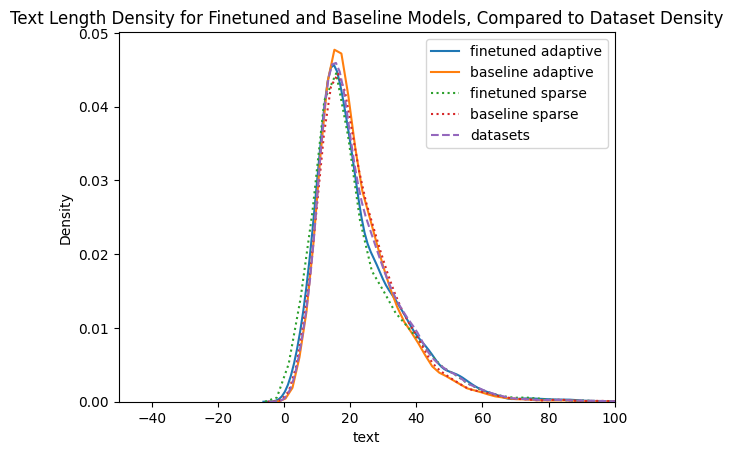

In [45]:
sns.kdeplot(finetuned_adaptive_df["text"].str.count(" "), label="finetuned adaptive")
sns.kdeplot(baseline_adaptive_df["text"].str.count(" "), label="baseline adaptive")
plt.legend()

sns.kdeplot(finetuned_sparse_df["text"].str.count(" "), label="finetuned sparse", linestyle="dotted")
sns.kdeplot(baseline_sparse_df["text"].str.count(" "), label="baseline sparse", linestyle="dotted")

sns.kdeplot(datasets_df["nb_words"], label="datasets", linestyle="dashed")
plt.title("Text Length Density for Finetuned and Baseline Models, Compared to Dataset Density")

plt.xlim([-50, 100])
plt.legend()
plt.show()

### Per Task
Let's compare the same graph, but for individual tasks instead. The goal is to see whether the examples where the models outperform roberta are different in length than those of the dataset.  

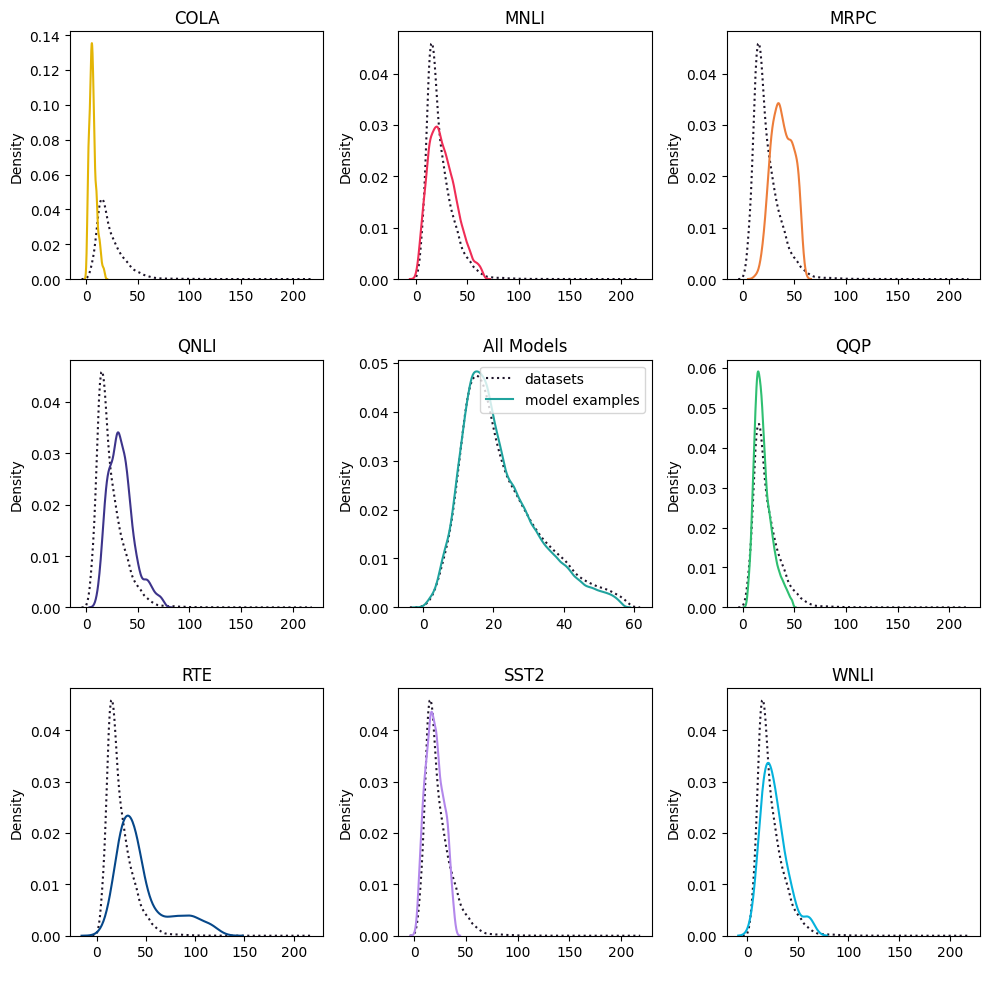

In [49]:
slice_frac = .98

shortened_datasets_df = datasets_df.copy().sort_values("nb_words")
shortened_datasets_df = shortened_datasets_df[:int(len(shortened_datasets_df.index)*slice_frac)]

plt.figure(figsize = (10, 10))
increment = 1
for i, task in enumerate(tasks):

    if i+1==5:
        temp_general_adaptive_df = general_adaptive_df.copy()
        temp_general_adaptive_df["nb_words"] = temp_general_adaptive_df["text"].str.count(" ")
        temp_general_adaptive_df = temp_general_adaptive_df.sort_values("nb_words")
        temp_general_adaptive_df = temp_general_adaptive_df[:int(len(temp_general_adaptive_df.index)*slice_frac)]

        plt.subplot(3, 3, i+increment)
        sns.kdeplot(shortened_datasets_df["nb_words"], linestyle="dotted", label="datasets", color = "#1E152A")
        sns.kdeplot(temp_general_adaptive_df["nb_words"], color = model_colors["adaptive"], label="model examples")
        plt.title("All Models")
        plt.legend()
        plt.xlabel(" ")
        increment += 1 
   
    plt.subplot(3, 3, i+increment)
    task_df = sparse_df[sparse_df["task"]==task]
    task_df["nb_words"] = task_df["text"].str.count(" ")
    task_df = task_df.sort_values("nb_words")
    task_df = task_df[:int(len(task_df.index)*slice_frac)]

    task_datasets_df = datasets_df.copy().sort_values("nb_words")
    task_datasets_df = task_datasets_df[:int(len(task_datasets_df.index)*.95)]


    sns.kdeplot(datasets_df["nb_words"], linestyle="dotted", color = "#1E152A")
    sns.kdeplot(task_df["nb_words"], color = task_colors[task])
    plt.title(task.upper())
    plt.xlabel(" ")

plt.tight_layout()
plt.show()